# This notebook aims at presenting the Cluster Ensemble stage functionalities

In [2]:
import os
from pprint import pprint
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
import ceci
import h5py
import yaml

Make sure to change your path in the next cell that leads to your TXPipe directory. See examples for IN2P3 and NERSC below.

In [3]:
#user specific paths -- IN2P3 example
my_txpipe_dir = "/pbs/home/m/mricci/throng_mricci/desc/TXPipe"

#user specific paths -- NERSC example
#my_txpipe_dir = "/pscratch/sd/a/avestruz/TXPipe"

os.chdir(my_txpipe_dir)

import txpipe

# Let's start working with the 1deg2 data file on Jupyter

First we will do some runs on the 1 deg^2 example data set with around 80k galaxies. This is small enough that we can do it all in jupyter.

The data set, which is based on CosmoDC2, contains pre-computed photo-z and and contains a RedMapper cluster catalog for the field.

## This initiates and run the stage

In [4]:
print("Options for this pipeline and their defaults:")
print(txpipe.extensions.CLClusterEnsembleProfiles.config_options)

pip_stage = txpipe.extensions.CLClusterEnsembleProfiles.make_stage(
    #cluster_catalog="./data/example/inputs/cluster_catalog.hdf5",
    cluster_shear_catalogs="./data/cosmodc2/outputs-1deg2-CL/cluster_shear_catalogs.hdf5",
    fiducial_cosmology="./data/fiducial_cosmology.yml",
    cluster_catalog_tomography="./data/cosmodc2/outputs-1deg2-CL/cluster_catalog_tomography.hdf5",
    

    # This is the output for this stage
    cluster_profiles="./data/cosmodc2/outputs-1deg2-CL/cluster_profiles.pkl",

    # This contains all the options for this stage. You can override them here, as we do with the max_radius below.
    config="./examples/cosmodc2/config-1deg2-CL.yml",    

)



Options for this pipeline and their defaults:
{'r_min': 0.2, 'r_max': 3.0, 'nbins': 5, 'delta_sigma_profile': True, 'shear_profile': False, 'magnification_profile': False}


In [5]:
print("Actual options used for this pipeline (as defined in config file or default):")
print(pip_stage.config)

Actual options used for this pipeline (as defined in config file or default):
{r_min:0.3,r_max:3.0,nbins:4,delta_sigma_profile:True,shear_profile:False,magnification_profile:False,cluster_shear_catalogs:./data/cosmodc2/outputs-1deg2-CL/cluster_shear_catalogs.hdf5,fiducial_cosmology:./data/fiducial_cosmology.yml,cluster_catalog_tomography:./data/cosmodc2/outputs-1deg2-CL/cluster_catalog_tomography.hdf5,cluster_profiles:./data/cosmodc2/outputs-1deg2-CL/cluster_profiles.pkl,config:./examples/cosmodc2/config-1deg2-CL.yml,aliases:{},}


In [6]:
pip_stage.run()
pip_stage.finalize()

[0.3        0.53348382 0.9486833  1.68702398 3.        ]
65968 65968 65968
bin_zbin_0_richbin_0 <HDF5 group "/cluster_bin/bin_zbin_0_richbin_0" (8 members)> 5
theta_max 13.683330543251138 = 3.2290998265188118 Mpc
GCData
> defined by: cosmo='CCLCosmology(H0=71.0, Omega_dm0=0.2199999, Omega_b0=0.0448, Omega_k0=0.0)', bin_units='Mpc'
> with columns: radius_min, radius, radius_max, tangential_comp, tangential_comp_err, cross_comp, cross_comp_err, z, z_err, n_src, W_l
> 4 objects
     radius_min           radius           radius_max     ... z_err n_src  W_l 
------------------- ------------------ ------------------ ... ----- ----- -----
0.29999999999999993 0.4258387859012772 0.5334838230116767 ...   0.0    24  24.0
 0.5334838230116767 0.7490677650809866 0.9486832980505137 ...   0.0    59  59.0
 0.9486832980505137 1.3484152213058525  1.687023975571047 ...   0.0   161 161.0
  1.687023975571047 2.3924501130602525                3.0 ...   0.0   564 564.0
theta_max 12.040790270002116 = 2.6702079

## This load and explore the outputs

In [7]:
import pickle as pkl

In [8]:
pip_stage.config['cluster_profiles']

'./data/cosmodc2/outputs-1deg2-CL/cluster_profiles.pkl'

In [9]:
data = pkl.load(open(pip_stage.config['cluster_profiles'],"rb"))

### The data is a dictionary with bin names as keys and CLMM.clusterEnsemble objects as associated data. When a bin has no cluster, the data is None.

In [10]:
data

{'bin_zbin_0_richbin_0': <clmm.clusterensemble.ClusterEnsemble at 0x7f906c32f0a0>,
 'bin_zbin_0_richbin_1': <clmm.clusterensemble.ClusterEnsemble at 0x7f90666c3880>,
 'bin_zbin_0_richbin_2': None,
 'bin_zbin_1_richbin_0': <clmm.clusterensemble.ClusterEnsemble at 0x7f9065fefd60>,
 'bin_zbin_1_richbin_1': <clmm.clusterensemble.ClusterEnsemble at 0x7f9065feec80>,
 'bin_zbin_1_richbin_2': None,
 'bin_zbin_2_richbin_0': <clmm.clusterensemble.ClusterEnsemble at 0x7f9065fee8c0>,
 'bin_zbin_2_richbin_1': <clmm.clusterensemble.ClusterEnsemble at 0x7f9065fed630>,
 'bin_zbin_2_richbin_2': <clmm.clusterensemble.ClusterEnsemble at 0x7f9065fee470>}

### Functions to plot the output

In [11]:
def plot_stacked_delta_sigma_profile(cl_stacked_data, title=None, ax=None):
    if ax==None:
        ax = plt.axes()

    ax.semilogx(cl_stacked_data.stacked_data['radius'],cl_stacked_data.stacked_data['tangential_comp'],'bx-',label="tan")
    ax.semilogx(cl_stacked_data.stacked_data['radius'],cl_stacked_data.stacked_data['cross_comp'],'ro-',label="cross")

    ax.errorbar(cl_stacked_data.stacked_data['radius'], cl_stacked_data.stacked_data['tangential_comp'], yerr=cl_stacked_data.cov['tan_sc'].diagonal() ** 0.5 , color='blue')
    ax.errorbar(cl_stacked_data.stacked_data['radius'], cl_stacked_data.stacked_data['cross_comp'], yerr=cl_stacked_data.cov['cross_sc'].diagonal() ** 0.5 , color='red')


    for i in range(len(cl_stacked_data)):
        ax.plot(
            cl_stacked_data.data["radius"][i],
            cl_stacked_data.data["tangential_comp"][i] ,
            "blue",
            #label="Individual",
            alpha=0.2,
            linewidth=1,
        )

    for i in range(len(cl_stacked_data)):
        ax.plot(
            cl_stacked_data.data["radius"][i],
            cl_stacked_data.data["cross_comp"][i] ,
            "red",
            #label="Individual",
            alpha=0.2,
            linewidth=1,
        )
    
    ax.legend()
    ax.set_ylabel('delta_sigma')
    ax.set_xlabel('radius')
    ax.set_title(title)


In [12]:
def plot_covariance(cl_stacked_data, cov_type='tan_sc', title=None, ax=None):
    if ax==None:
        ax = plt.axes()

    cov = ax.imshow(cl_stacked_data.cov[cov_type], origin='lower')
    plt.colorbar(cov, ax=ax)
    
    ax.set_ylabel('radius')
    ax.set_xlabel('radius')
    ax.set_title(title)


### Plot stacked profile

bin_zbin_0_richbin_0
bin_zbin_0_richbin_1
bin_zbin_0_richbin_2
bin_zbin_1_richbin_0
bin_zbin_1_richbin_1
bin_zbin_1_richbin_2
bin_zbin_2_richbin_0
bin_zbin_2_richbin_1
bin_zbin_2_richbin_2


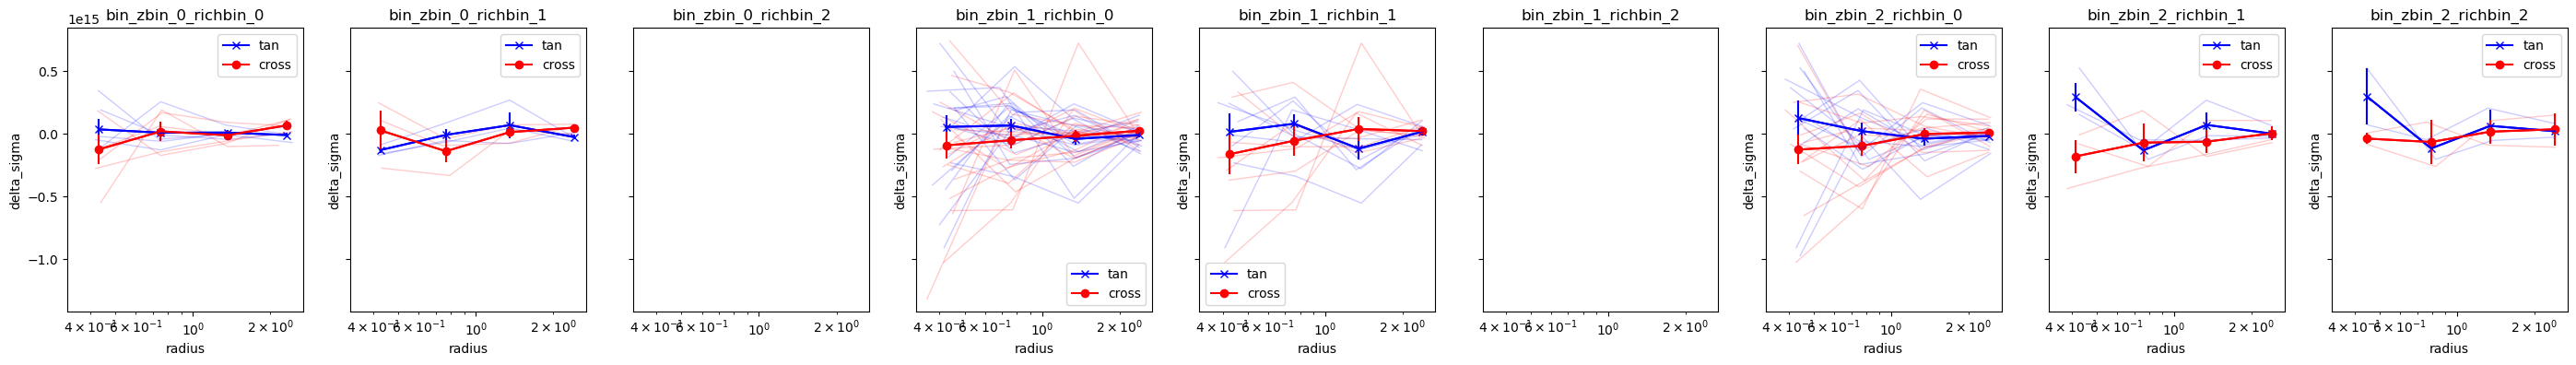

In [13]:
fig, axs = plt.subplots(1, len(data), sharex=True, sharey=True, figsize=(35, 4))
i=0
ax1=axs[0]
for k in data.keys():
    print(k)
    if data[k]!=None:
        plot_stacked_delta_sigma_profile(data[k], data[k].unique_id , ax=ax1)
    else :
         ax1.set_title(k)
        
    i=min(i+1, len(data.keys()) - 1)
    ax1=axs[0+i]  


### Plot covariance

bin_zbin_0_richbin_0
bin_zbin_0_richbin_1
bin_zbin_0_richbin_2
bin_zbin_1_richbin_0
bin_zbin_1_richbin_1
bin_zbin_1_richbin_2
bin_zbin_2_richbin_0
bin_zbin_2_richbin_1
bin_zbin_2_richbin_2


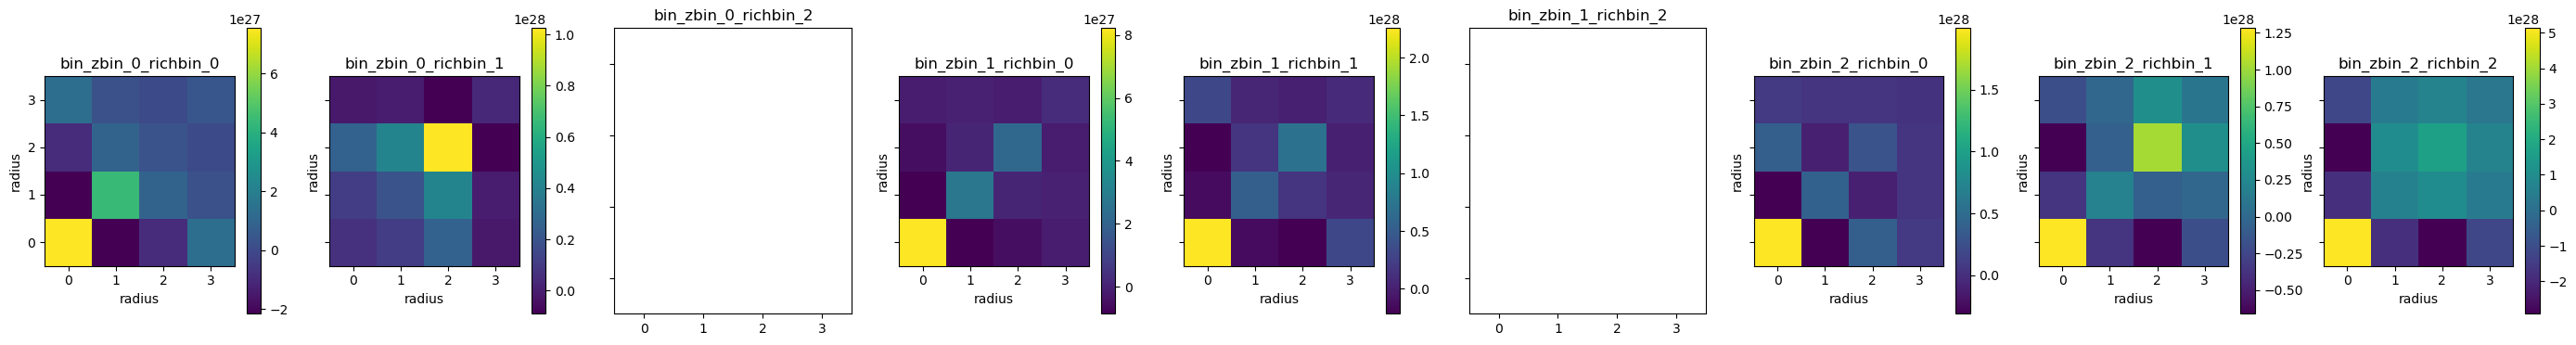

In [14]:
fig, axs = plt.subplots(1, len(data), sharex=True, sharey=True, figsize=(35, 4))
i=0

ax2=axs[0]
for k in data.keys():
    print(k)
    if data[k]!=None:
        plot_covariance(data[k], cov_type='tan_sc', title = data[k].unique_id , ax=ax2)
    else :
         ax2.set_title(k)    
    i=min(i+1, len(data.keys()) - 1)
    ax2=axs[0+i]

# Let's now use the pipeline approach

Here we will use the 20deg2, but we can also use the 1deg2 files (just need to change 20deg2 to 1deg2 in the name of the files)

### Launching a pipeline

Let's have a look at the submission script for this pipeline:
- to work at CCin2p3 we can use: `examples/Cluster_pipelines/cosmodc2/20deg2-in2p3.sub`:
- to work at NERSC we can use: `examples/Cluster_pipelines/cosmodc2/20deg2-nersc.sub`:

## This comand will run the pipeline



> ### In a terminal, **navigate to your TXPipe directory on IN2P3 and run**:
>```
sbatch examples/Cluster_pipelines/cosmodc2/1deg2-in2p3.sub
```


> ### If you are **on NERSC, you will instead run**:
>```
sbatch examples/Cluster_pipelines/cosmodc2/1deg2-nersc.sub
```

## Let's look at the file content 

### Let's look at the submission_script :

=> If we use the CCin2p3 example:

In [15]:
#! cat examples/Cluster_pipelines/cosmodc2/1deg2-in2p3.sub

= > If we use the NERSC example:

In [16]:
#! cat examples/cosmodc2/1deg2-nersc.sub

### Let's look at the pipeline_file :

=> If we use the CCin2p3 example:

In [17]:
#! cat examples/cosmodc2/pipeline-1deg2-CL-in2p3.yml

= > If we use the NERSC example:

In [18]:
#! cat examples/cosmodc2/pipeline-1deg2-CL-nersc.yml

## This will test the pipeline and produce a flowchart plot
! The pipeline used here as the other stages commented to only highlight in the flowchart the CLClusterEnsembleProfiles stage.
The config file is the same. The file is written for in2p3 but it does not matter as it is a dry-run.

In [48]:
# Read the appropriate pipeline configuration, and ask for a flow-chart.
pipeline_file = "examples/cosmodc2/Cluster_pipelines/CLClusterEnsemble-20deg2-CL.yml"
#pipeline_file = "examples/cosmodc2/pipeline-1degCLClusterBinning2-CL-nersc.yml"
flowchart_file = "CLClusterEnsemble.png"


pipeline_config = ceci.Pipeline.build_config(
    pipeline_file,
    flow_chart=flowchart_file,
    dry_run=True
)

# Run the flow-chart pipeline
ceci.run_pipeline(pipeline_config)

0

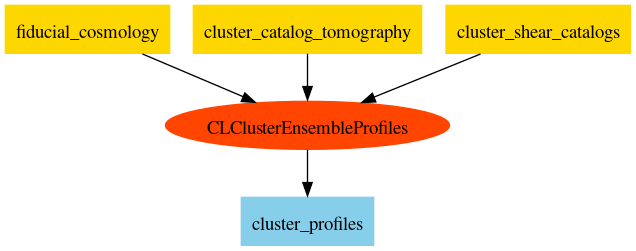

In [49]:
Image(flowchart_file)

## This loads and explore the outputs

In [50]:
with open(pipeline_file, 'r') as file:
    pipeline_content = yaml.safe_load(file)


In [51]:
filename_out =pipeline_content['output_dir']+"/cluster_profiles.pkl"

In [52]:
filename_out

'./data/cosmodc2/outputs-20deg2-CL/cluster_profiles.pkl'

In [53]:
data = pkl.load(open(filename_out,"rb"))

In [54]:
with open(yaml.safe_load(pipeline_content['config']), 'r') as file:
    config_content = yaml.safe_load(file)

In [55]:
config_bin_info = config_content['CLClusterBinningRedshiftRichness']

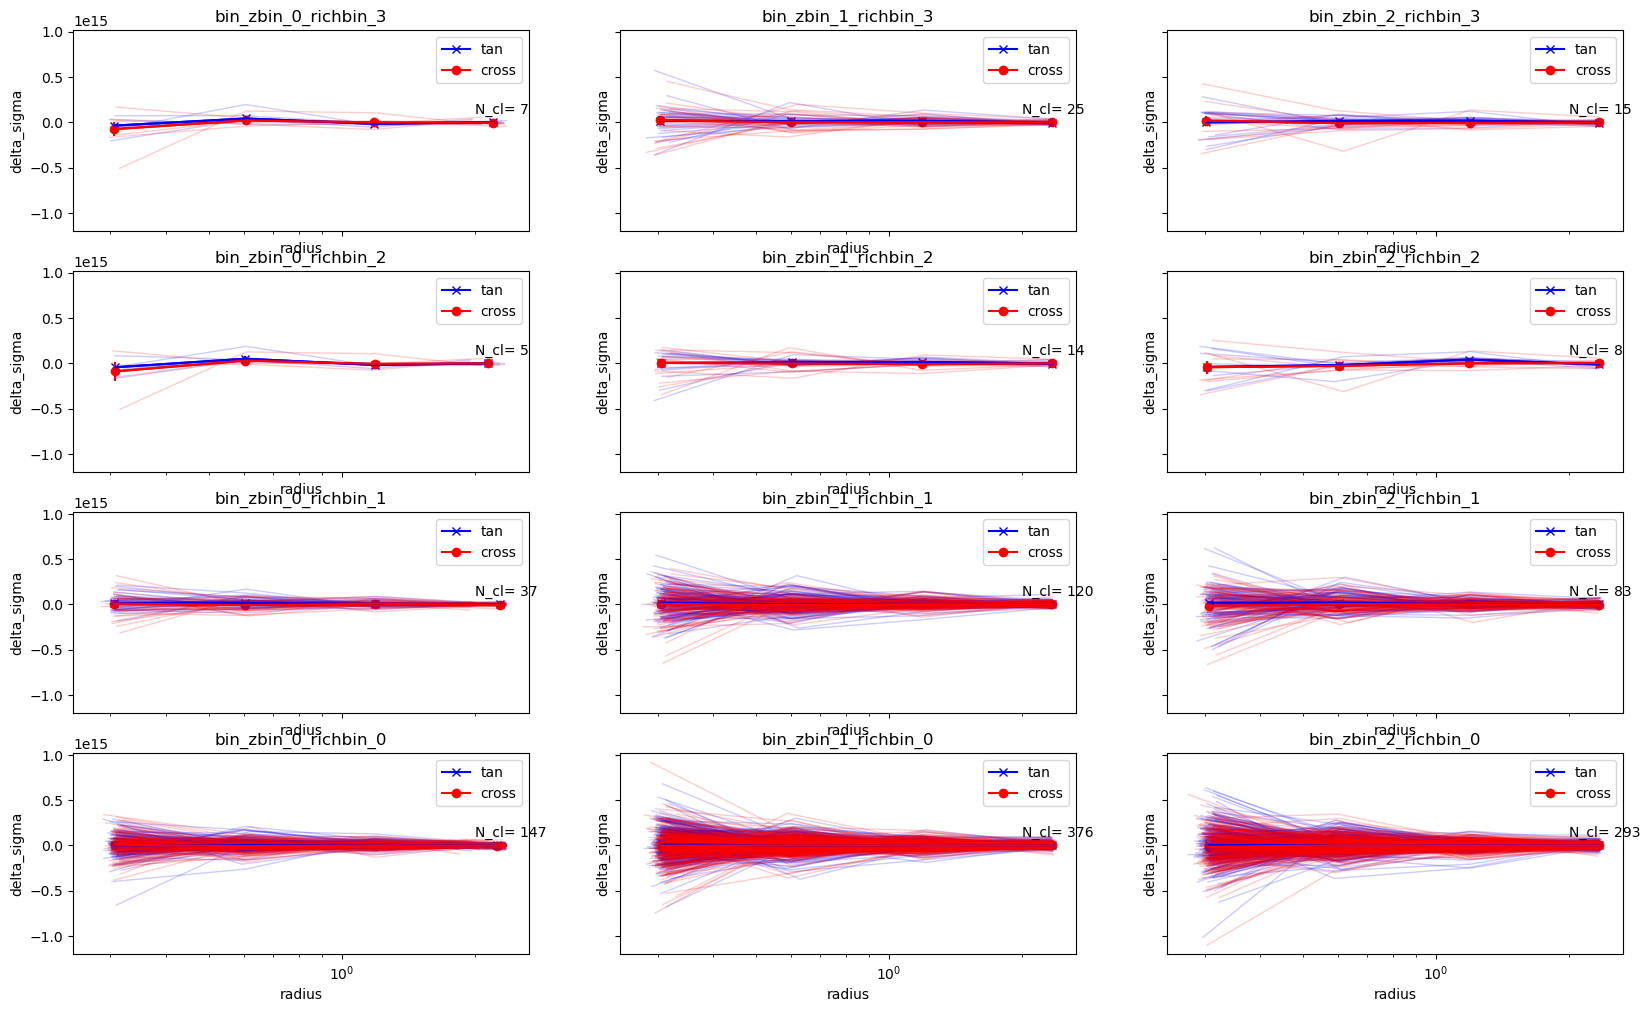

In [56]:
fig, axs = plt.subplots(len(config_bin_info['richedge'])-1, len(config_bin_info['zedge'])-1, sharex=True, sharey=True, figsize=(20, 12))

for i in range(len(config_bin_info['zedge'])-1):
    for j in range(len(config_bin_info['richedge'])-1):
        bin_name='bin_zbin_'+str(i)+'_richbin_'+str(j)
        if data[bin_name]!=None:
            plot_stacked_delta_sigma_profile(data[bin_name], data[bin_name].unique_id , ax=axs[len(config_bin_info['richedge']) -2 -j,i])
        else :
            axs[len(config_bin_info['richedge']) -2 -j,i].set_title(bin_name)      
            
        axs[len(config_bin_info['richedge']) -2 -j,i].text(2, 1e14, 'N_cl= '+ str(len(data[bin_name].data)))  
